# Prep

In [9]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

import warnings
warnings.filterwarnings("ignore")


# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
from plotting_helpers import *           # truncate_colormap

In [10]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [11]:
# iB = 6
m = 0
s = 1
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [12]:
# read one basin or whole ASTE
whole = True
if not whole:
    iB = 6    # example read from BarentsSea

In [13]:
annual = False

In [14]:
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [15]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,9])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [16]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

if annual:
    theta = np.nanmean(theta,axis=0)
    salt = np.nanmean(salt,axis=0)

In [17]:
# also calculate surface rho from theta and salt
rho = gsw.rho(salt,theta,0)
rho.shape

(2, 50, 1350, 270)

In [18]:
# first have to get the vector values from U and V
file_name = "budg3d_hflux_set2"
# UVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['UVELMASS']),mymsk,dirIn)
# VVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['VVELMASS']),mymsk,dirIn)
ADVx_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_TH']),mymsk,dirIn)     # degC m^3/s
ADVy_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_TH']),mymsk,dirIn)
DFxE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_TH']),mymsk,dirIn)
DFyE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_TH']),mymsk,dirIn)
ADVx_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_SLT']),mymsk,dirIn)   # PSU m^3/s
ADVy_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_SLT']),mymsk,dirIn)
DFxE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_SLT']),mymsk,dirIn)
DFyE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_SLT']),mymsk,dirIn)

if annual:
    ADVx_TH = np.nanmean(ADVx_TH,axis=0)
    ADVy_TH = np.nanmean(ADVy_TH,axis=0)
    DFxE_TH = np.nanmean(DFxE_TH,axis=0)
    DFyE_TH = np.nanmean(DFyE_TH,axis=0)
    ADVx_SLT = np.nanmean(ADVx_SLT,axis=0)
    ADVy_SLT = np.nanmean(ADVy_SLT,axis=0)
    DFxE_SLT = np.nanmean(DFxE_SLT,axis=0)
    DFyE_SLT = np.nanmean(DFyE_SLT,axis=0)

In [19]:
file_name = "budg3d_zflux_set2"
ADVr_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_SLT']),mymsk,dirIn)
ADVr_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_TH']),mymsk,dirIn)
DFrE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_SLT']),mymsk,dirIn)
DFrE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFrE_TH']),mymsk,dirIn)

if annual:
    ADVr_SLT = np.nanmean(ADVr_SLT,axis=0)
    ADVr_TH = np.nanmean(ADVr_TH,axis=0)
    DFrE_SLT = np.nanmean(DFrE_SLT,axis=0)
    DFrE_TH = np.nanmean(DFrE_TH,axis=0)

In [20]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)
if annual:
    vol = np.nanmean(vol,axis=0)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [21]:
# budg2d_zflux_set1: SIatmFW, oceFWflx
file_name = "budg2d_zflux_set1"
SIatmFW = read_field2d(tsstr,ny,nx,file_name,np.array(['SIatmFW']),mymsk,dirIn)
oceFWflx = read_field2d(tsstr,ny,nx,file_name,np.array(['oceFWflx']),mymsk,dirIn)

if annual:
    SIatmFW = np.nanmean(SIatmFW,axis=0)
    oceFWflx = np.nanmean(oceFWflx,axis=0)

# create the TS bins

In [22]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [23]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [27]:
print(strb[0:7])
# plt.pcolormesh(get_aste_tracer(mskBasin,nfx,nfy)[0] * get_aste_tracer(mymsk,nfx,nfy)[0])
maskArc = mskBasin * mymsk
# plt.colorbar()
# plt.xlim(290,540)
# plt.ylim(400,860)

['CanadaB' 'ChukchiS' 'MakarovB' 'AmundsenB' 'NansenB' 'BeringS'
 'BarentsS']


In [28]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

# try to select from BarentsS

In [29]:
iB = 6
print(strb[iB])

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs,dT,dS)
print(mesh.shape)

mydata_test_m1 = np.nansum(mesh[m],axis=2)#/binwidthsS_tile/binwidthsT_tile    # this has already been done in the function!!
mydata_test_m2 = np.nansum(mesh[s],axis=2)#/binwidthsS_tile/binwidthsT_tile

# make a mask for iB so we can multiply the advective terms
mymsk_iB = mskBasin.copy()

# Create a boolean mask for elements iB
mask = (mymsk_iB==6) 

# Set non iB elements to nan
mymsk_iB[mask] = 1
mymsk_iB[~mask] = np.nan
mymsk_iB = np.tile(mymsk_iB,(50,1,1))

BarentsS
(2, 112, 112, 10650)


# create the vectors for a surface term (ie oceFWflx)

In [33]:
# create the bin widths
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T        # equivalent of dS
binwidthsT_tile = np.tile(binwidthT, (112, 1))          # equivalent to dT

# select the values of interest and change units

# try to plot again for DFE or ADV

In [35]:
# we already have distrADVx_SLT and distrADVx_TH, we need to repeat the process for y and z

# let's try to write a function such that we can create these diagrams for any average or file

def create_TS_mesh_vectors(attr_x,attr_y,attr_r,binned_theta,binned_salinity,nT,nS,binwidthS,binwidthT):
    '''
    Creates the tendency terms for a given attribute provided the X,Y, and Z components
    
    Inputs:
        attr_x: the attribute we want in the x direction (ie ADVx_TH)
        attr_y: the attribute we want in y (ie ADVy_TH)
        attr_r: the attribute in z (ie ADVr_TH)
        nT, nS: number of cell centers
        binwidthT, binwidthS: bin widths in T-S space for comparison

    Outputs:
        an array of shape nT, nS of the tendency values for a given basin or set of basins
    '''
    # initialize the TS mesh
    distr_attr = np.full((nT,nS),0.0)

    # initialize tiles for binwidths
    binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
    binwidthsT_tile = np.tile(binwidthT, (112, 1))

    # get the indices where not nan so that we don't have to loop, hopefully faster
    indices = np.where(~np.isnan(binned_theta))
    if len(indices) == 2:
        y,x = indices[0],indices[1]
    else:
        z,y,x = indices[0],indices[1],indices[2]

    # loop over the z,y,x indices, grab the values from attr, and add them to the mesh
    # 2D case (ie gate)
    if len(indices) == 2:
        for i,j in zip(y,x):
            distr_attr[int(binned_salinity[i,j]),int(binned_theta[i,j])] += attr_x[i,j]
            distr_attr[int(binned_salinity[i,j]),int(binned_theta[i,j])] += attr_y[i,j]

    # 3D case (ie Basin)
    elif len(indices) == 3:
        for i,j,k in zip(z,y,x):
            distr_attr[int(binned_salinity[i,j,k]),int(binned_theta[i,j,k])] += attr_x[i,j,k]    # degC.m^3/s OR PSU.m^3/s
            distr_attr[int(binned_salinity[i,j,k]),int(binned_theta[i,j,k])] += attr_y[i,j,k]
            distr_attr[int(binned_salinity[i,j,k]),int(binned_theta[i,j,k])] += attr_r[i,j,k]

    # divide by binwidthsS and binwidthsT tiles
    # heat tendency becomes Sv/PSU, salt tendency becomes Sv/degC
    distr_attr  = distr_attr/binwidthsT_tile[:,:]/binwidthsS_tile[:,:]    # m^3/s/PSU OR m^3/s/degC
    distr_attr *= 1e-6                                                    # Sv/PSU or Sv/degC
    distr_attr[distr_attr == 0 ] = np.nan

    return distr_attr

In [46]:
# grab the advective terms and multiply by mymsk_iB
ADVx_TH_iB = ADVx_TH[m] * mymsk_iB      # degC.m^3/s
ADVy_TH_iB = ADVy_TH[m] * mymsk_iB
ADVr_TH_iB = ADVr_TH[m] * mymsk_iB

# also grab the salt values here
ADVx_SLT_iB = ADVx_SLT[m] * mymsk_iB    # PSU.m^3/s
ADVy_SLT_iB = ADVy_SLT[m] * mymsk_iB
ADVr_SLT_iB = ADVr_SLT[m] * mymsk_iB

# grab the basin bin values
binned_theta_iB = binned_theta[m] * mymsk_iB
binned_salinity_iB = binned_salinity[m] * mymsk_iB

# try to run the function
# first - feed in m^3.degC/PSU - TH goes away to become Sv/PSU -- y component of advection
distr_y_iB_m1 = create_TS_mesh_vectors(ADVx_TH_iB,ADVy_TH_iB,ADVr_TH_iB,binned_theta_iB,binned_salinity_iB,nT,nS,binwidthS,binwidthT)
# inputting SLT as the attribute becomes Sv/degC
distr_x_iB_m1 = create_TS_mesh_vectors(ADVx_SLT_iB,ADVy_SLT_iB,ADVr_SLT_iB,binned_theta_iB,binned_salinity_iB,nT,nS,binwidthS,binwidthT)

In [47]:
# grab the advective terms and multiply by mymsk_iB
ADVx_TH_iB = ADVx_TH[s] * mymsk_iB      # degC.m^3/s
ADVy_TH_iB = ADVy_TH[s] * mymsk_iB
ADVr_TH_iB = ADVr_TH[s] * mymsk_iB

# also grab the salt values here
ADVx_SLT_iB = ADVx_SLT[s] * mymsk_iB    # PSU.m^3/s
ADVy_SLT_iB = ADVy_SLT[s] * mymsk_iB
ADVr_SLT_iB = ADVr_SLT[s] * mymsk_iB

# grab the basin bin values
binned_theta_iB = binned_theta[s] * mymsk_iB
binned_salinity_iB = binned_salinity[s] * mymsk_iB

# try to run the function
distr_y_iB_m2 = create_TS_mesh_vectors(ADVx_TH_iB,ADVy_TH_iB,ADVr_TH_iB,binned_theta_iB,binned_salinity_iB,nT,nS,binwidthS,binwidthT)
distr_x_iB_m2 = create_TS_mesh_vectors(ADVx_SLT_iB,ADVy_SLT_iB,ADVr_SLT_iB,binned_theta_iB,binned_salinity_iB,nT,nS,binwidthS,binwidthT)

In [48]:
# get a normalization factor for these arrows

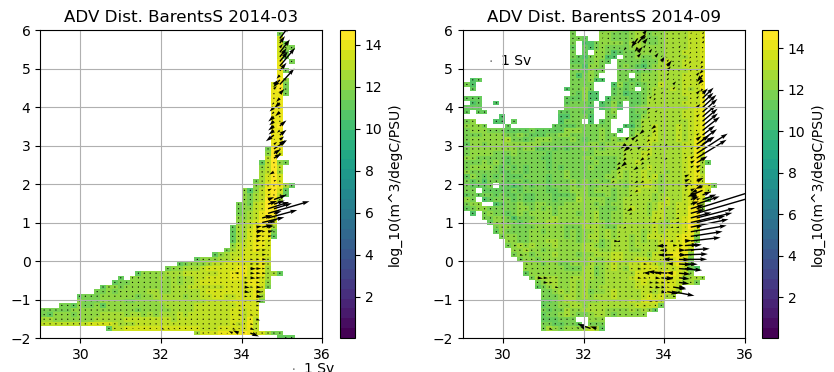

In [49]:
fig = plt.figure(figsize=(10,4))

scale=1e3

# March
ax1 = plt.subplot(121)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent, distr_x_iB_m1/8, distr_y_iB_m1,width=0.005) #,scale=scale)  # X dir - Sv/degC, Y dir - Sv/PSU
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("ADV Dist. " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

# Add quiver key for the first subplot
ax1.quiverkey(q1, X=0.9, Y=-0.1, U=10, label='1 Sv', labelpos='E')

# September
ax2 = plt.subplot(122)
cb2 = ax2.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2), cmap=cmap2, vmin=0.01)
q2 = ax2.quiver(Sbincent, Tbincent, distr_x_iB_m2/8, distr_y_iB_m2,width=0.005) #,scale=scale)  # X dir - Sv/degC, Y dir - Sv/PSU
plt.colorbar(cb2, label="log_10(m^3/degC/PSU)")
ax2.set_title("ADV Dist. " + strb[iB] + " " + datetimes[s].strftime("%Y-%m"))
ax2.set_xlim(29,36)
ax2.set_ylim(-2,6)
ax2.grid()

# Add quiver key for the second subplot
ax2.quiverkey(q2, X=0.1, Y=0.9, U=10, label='1 Sv', labelpos='E')

# try for diffusive

In [50]:
# grab the advective terms and multiply by mymsk_iB
DFxE_TH_iB = DFxE_TH[m] * mymsk_iB
DFyE_TH_iB = DFyE_TH[m] * mymsk_iB
DFrE_TH_iB = DFrE_TH[m] * mymsk_iB

# also grab the salt values here
DFxE_SLT_iB = DFxE_SLT[m] * mymsk_iB
DFyE_SLT_iB = DFyE_SLT[m] * mymsk_iB
DFrE_SLT_iB = DFrE_SLT[m] * mymsk_iB

# grab the basin bin values
binned_theta_iB = binned_theta[m] * mymsk_iB
binned_salinity_iB = binned_salinity[m] * mymsk_iB

# try to run the function
DFE_distr_y_iB_m1 = create_TS_mesh_vectors(DFxE_TH_iB,DFyE_TH_iB,DFrE_TH_iB,binned_theta_iB,binned_salinity_iB,nT,nS,binwidthS,binwidthT)
DFE_distr_x_iB_m1 = create_TS_mesh_vectors(DFxE_SLT_iB,DFyE_SLT_iB,DFrE_SLT_iB,binned_theta_iB,binned_salinity_iB,nT,nS,binwidthS,binwidthT)
# and this is so much faster than the looping we did before!

In [51]:
# grab the advective terms and multiply by mymsk_iB
DFxE_TH_iB = DFxE_TH[s] * mymsk_iB
DFyE_TH_iB = DFyE_TH[s] * mymsk_iB
DFrE_TH_iB = DFrE_TH[s] * mymsk_iB

# also grab the salt values here
DFxE_SLT_iB = DFxE_SLT[s] * mymsk_iB
DFyE_SLT_iB = DFyE_SLT[s] * mymsk_iB
DFrE_SLT_iB = DFrE_SLT[s] * mymsk_iB

# grab the basin bin values
binned_theta_iB = binned_theta[s] * mymsk_iB
binned_salinity_iB = binned_salinity[s] * mymsk_iB

# try to run the function
DFE_distr_y_iB_m2 = create_TS_mesh_vectors(DFxE_TH_iB,DFyE_TH_iB,DFrE_TH_iB,binned_theta_iB,binned_salinity_iB,nT,nS,binwidthS,binwidthT)
DFE_distr_x_iB_m2 = create_TS_mesh_vectors(DFxE_SLT_iB,DFyE_SLT_iB,DFrE_SLT_iB,binned_theta_iB,binned_salinity_iB,nT,nS,binwidthS,binwidthT)
# and this is so much faster than the looping we did before!

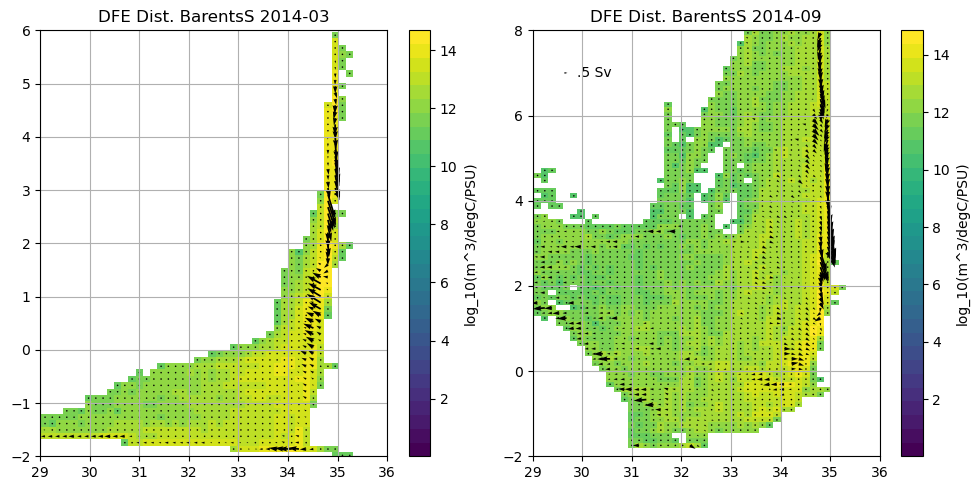

In [58]:
# try to plot an example
fig = plt.figure(figsize=(10,5))

# March
ax1 = plt.subplot(121)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent, DFE_distr_x_iB_m1,-DFE_distr_y_iB_m1/8,width=0.005)  # in units of m^3/s
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("DFE Dist. " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

# Add quiver key for the first subplot
ax1.quiverkey(q1, X=0.9, Y=-0.1, U=.5, label='.5 Sv', labelpos='E')

# April
ax2 = plt.subplot(122)
cb2 = ax2.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2), cmap=cmap2, vmin=0.01)
q2 = ax2.quiver(Sbincent, Tbincent,  DFE_distr_x_iB_m2,-DFE_distr_y_iB_m2/8,width=0.005)  # in units of m^3/s
plt.colorbar(cb2, label="log_10(m^3/degC/PSU)")
ax2.set_title("DFE Dist. " + strb[iB] + " " + datetimes[s].strftime("%Y-%m"))
ax2.set_xlim(29,36)
ax2.set_ylim(-2,8)
ax2.grid()

# Add quiver key for the second subplot
ax2.quiverkey(q2, X=0.1, Y=0.9, U=.5, label='.5 Sv', labelpos='E')

plt.tight_layout()
plt.show()

# maybe plot just march

In [189]:
SIatmFW_fX_dT,SIatmFW_fY_dS = get_surface_distr(indices,SIatmFW,m,RAC,rho,nT,nS,binned_salinity,binned_theta)
oceFWflx_fX_dT,oceFWflx_fY_dS = get_surface_distr(indices,oceFWflx,m,RAC,rho,nT,nS,binned_salinity,binned_theta)

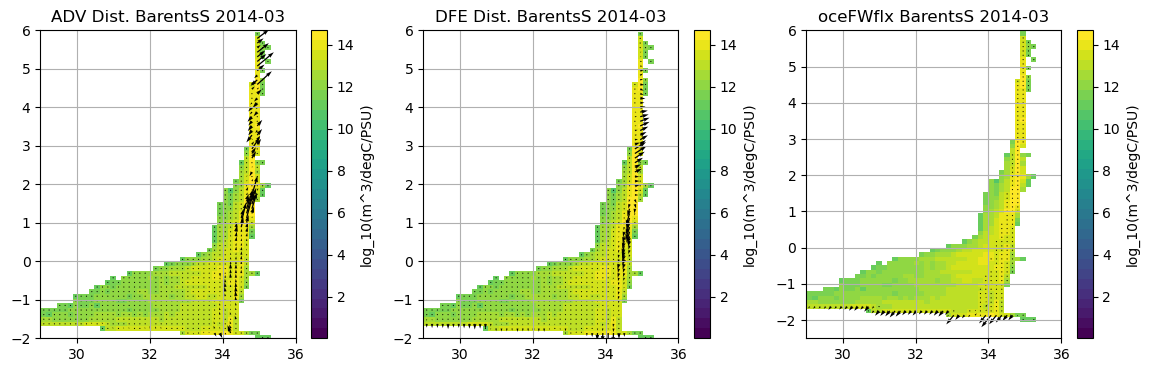

In [190]:
fig = plt.figure(figsize=(14,4))


ax1 = plt.subplot(131)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent, distr_TH_iB_m1,distr_SLT_iB_m1/8, width=0.005)    # x units are Sv/PSU, y units are Sv/degC
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("ADV Dist. " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

ax1 = plt.subplot(132)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent, DFE_distr_TH_iB_m1/16,DFE_distr_SLT_iB_m1, width=0.005)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("DFE Dist. " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

ax1 = plt.subplot(133)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
q1 = ax1.quiver(Sbincent, Tbincent, (oceFWflx_fX_dT), (oceFWflx_fY_dS),width=0.005)    # Sv/PSU, Sv/degC
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("oceFWflx " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2.5,6)
ax1.grid()

In [191]:
def scale_vectors(U, V):
    magnitude = np.sqrt(U**2 + V**2)
    # Apply square root scaling
    scaled_magnitude = np.sqrt(magnitude)
    # Reconstruct the vectors with scaled magnitudes
    scale_factor = scaled_magnitude / magnitude
    U_scaled = U * scale_factor
    V_scaled = V * scale_factor
    return U_scaled, V_scaled

# Original vectors
U = distr_SLT_iB_m1    # Sv/degC
V = distr_TH_iB_m1     # Sv/PSU

# Scale vectors
U1, V1 = scale_vectors(U, V)

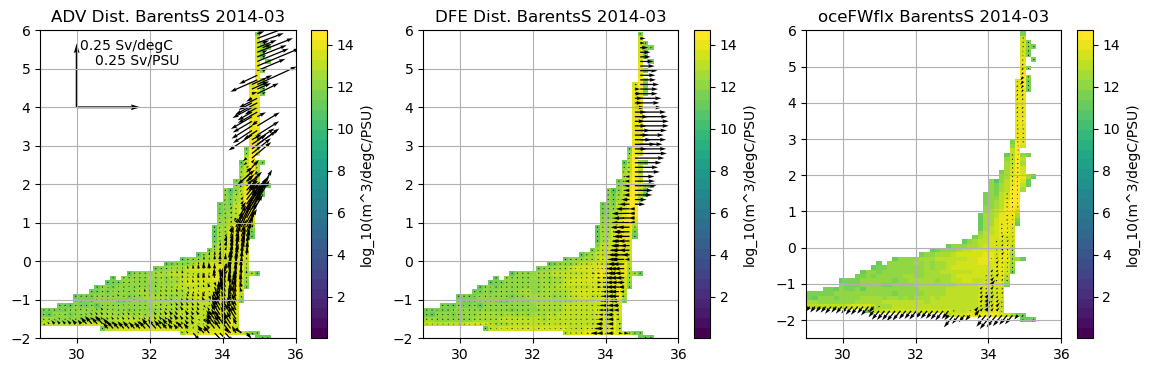

In [192]:
# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(14,4))

sfact = 16   # scale factor for x (PSU in denom, multiply out)
arrow_length = .25     # for the sverdrup arrows

ax1 = plt.subplot(131)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = scale_vectors(distr_TH_iB_m1*sfact, distr_SLT_iB_m1)       # x units are Sv/PSU, y units are Sv/degC
q1 = ax1.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=1e3)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("ADV Dist. " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()
ax1.quiver(30, 4, arrow_length, 0, scale=1, color='black')
ax1.annotate(f'{arrow_length} Sv/PSU', xy=(30.5, 5.1), color='black')
# Annotate vertical arrow
ax1.quiver(30, 4, 0, arrow_length, scale=1, color='black')
ax1.annotate(f'{arrow_length} Sv/degC', xy=(30.1, 5.5), color='black')

ax1 = plt.subplot(132)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = scale_vectors(DFE_distr_TH_iB_m1*sfact, DFE_distr_SLT_iB_m1)   # x units are Sv/PSU, y units are Sv/degC
q1 = ax1.quiver(Sbincent, Tbincent, U1, V1,width=0.005,scale=4e2)               
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("DFE Dist. " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

ax1 = plt.subplot(133)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m1), cmap=cmap2, vmin=0.01)
U1, V1 = scale_vectors(oceFWflx_fX_dT, oceFWflx_fY_dS)
q1 = ax1.quiver(Sbincent, Tbincent, U1, V1,width=0.005,scale=3)       # Sv/PSU, Sv/degC
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("oceFWflx " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2.5,6)
ax1.grid()

plt.savefig(path + "example_tenencies_MarchBarents_v3.png",dpi=300)

In [193]:
oceFWflx_fX_dT,oceFWflx_fY_dS = get_surface_distr(indices,oceFWflx,s,RAC,rho,nT,nS,binned_salinity,binned_theta)

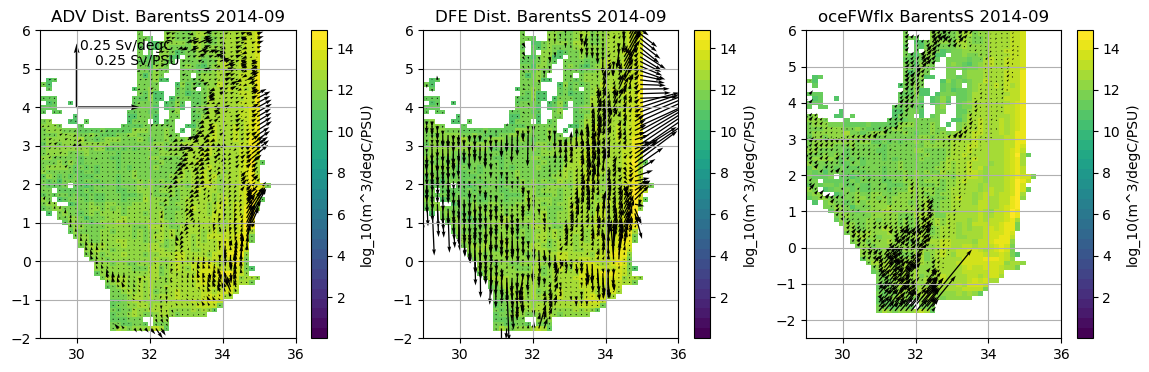

In [194]:
# remake the previous figure with scaled arrows
fig = plt.figure(figsize=(14,4))

sfact = 16   # scale factor for x (PSU in denom, multiply out)
arrow_length = .25     # for the sverdrup arrows

ax1 = plt.subplot(131)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2), cmap=cmap2, vmin=0.01)
U1, V1 = scale_vectors(distr_TH_iB_m2*sfact, distr_SLT_iB_m2)       # x units are Sv/PSU, y units are Sv/degC
q1 = ax1.quiver(Sbincent, Tbincent, U1, V1, width=0.005,scale=1e3)
# q1 = ax1.quiver(Sbincent, Tbincent, distr_TH_iB_m2*sfact, distr_SLT_iB_m2, width=0.005,scale=1e5)
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("ADV Dist. " + strb[iB] + " " + datetimes[s].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()
ax1.quiver(30, 4, arrow_length, 0, scale=1, color='black')
ax1.annotate(f'{arrow_length} Sv/PSU', xy=(30.5, 5.1), color='black')
# Annotate vertical arrow
ax1.quiver(30, 4, 0, arrow_length, scale=1, color='black')
ax1.annotate(f'{arrow_length} Sv/degC', xy=(30.1, 5.5), color='black')

ax1 = plt.subplot(132)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2), cmap=cmap2, vmin=0.01)
U1, V1 = scale_vectors(DFE_distr_TH_iB_m2*sfact, DFE_distr_SLT_iB_m2)   # x units are Sv/PSU, y units are Sv/degC
q1 = ax1.quiver(Sbincent, Tbincent, DFE_distr_TH_iB_m2/16, DFE_distr_SLT_iB_m2,width=0.005,scale=10)               
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("DFE Dist. " + strb[iB] + " " + datetimes[s].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2,6)
ax1.grid()

ax1 = plt.subplot(133)
cb1 = ax1.pcolormesh(Sbin, Tbin, np.log10(mydata_test_m2), cmap=cmap2, vmin=0.01)
U1, V1 = scale_vectors(oceFWflx_fX_dT, oceFWflx_fY_dS)
q1 = ax1.quiver(Sbincent, Tbincent, U1, V1,width=0.005,scale=1)       # Sv/PSU, Sv/degC
plt.colorbar(cb1, label="log_10(m^3/degC/PSU)")
ax1.set_title("oceFWflx " + strb[iB] + " " + datetimes[s].strftime("%Y-%m"))
ax1.set_xlim(29,36)
ax1.set_ylim(-2.5,6)
ax1.grid()

plt.savefig(path + "example_tenencies_SeptemberBarents.png",dpi=300)